# Market Profile and Support/Resistance Levels With Python

In this video I show python code to create the market profile with a kernel density estimate (a.k.a Parzen window). We find and filter peaks of the market profile using prominence to extract support and resistance levels. The code has customizable time weighting to allow for quicker identification of the levels for real time use.  I show a simple trend following strategy that buys on the penetration of the levels with decent performance.  This tool can be used to implement algorithmic trading strategies that require current support/resistance levels.

* Tutorial: [Market Profile and Support/Resistance Levels With Python](https://www.youtube.com/watch?v=mNWPSFOVoYA)
* Full Code: https://github.com/neurotrader888/TechnicalAnalysisAutomation

Prominence Scipy:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_prominences.html#scipy.signal.peak_prominences

Prominence Wikipedia: https://en.wikipedia.org/wiki/Topographic_prominence

Parzen Window: https://en.wikipedia.org/wiki/Kernel_density_estimation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import scipy
import math
import pandas_ta as ta

In [2]:
def find_levels( 
        price: np.array, atr: float, # Log closing price, and log atr 
        first_w: float = 0.1, 
        atr_mult: float = 3.0, 
        prom_thresh: float = 0.1
):

    # Setup weights
    last_w = 1.0
    w_step = (last_w - first_w) / len(price)
    weights = first_w + np.arange(len(price)) * w_step
    weights[weights < 0] = 0.0

    # Get kernel of price. 
    kernal = scipy.stats.gaussian_kde(price, bw_method=atr*atr_mult, weights=weights)

    # Construct market profile
    min_v = np.min(price)
    max_v = np.max(price)
    step = (max_v - min_v) / 200
    price_range = np.arange(min_v, max_v, step)
    pdf = kernal(price_range) # Market profile

    # Find significant peaks in the market profile
    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = scipy.signal.find_peaks(pdf, prominence=prom_min)
    levels = [] 
    for peak in peaks:
        levels.append(np.exp(price_range[peak]))

    return levels, peaks, props, price_range, pdf, weights

In [3]:
def support_resistance_levels(
        data: pd.DataFrame, lookback: int, 
        first_w: float = 0.01, atr_mult:float=3.0, prom_thresh:float =0.25
):

    # Get log average true range, 
    atr = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)

    all_levels = [None] * len(data)
    for i in range(lookback, len(data)):
        i_start  = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['close'].to_numpy())
        levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels
        
    return all_levels

In [4]:
def sr_penetration_signal(data: pd.DataFrame, levels: list):
    signal = np.zeros(len(data))
    curr_sig = 0.0
    close_arr = data['close'].to_numpy()
    for i in range(1, len(data)):
        if levels[i] is None:
            continue

        last_c = close_arr[i - 1]
        curr_c = close_arr[i]

        
        for level in levels[i]:
            if curr_c > level and last_c <= level: # Close cross above line
                curr_sig = 1.0
            elif curr_c < level and last_c >= level: # Close cross below line
                curr_sig = -1.0

        signal[i] = curr_sig
    return signal

In [5]:
def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['percent'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price'] 
    short_trades['percent'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    return long_trades, short_trades

In [6]:
# Load data

data = pd.read_csv('src/BTCUSDT86400.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [7]:
# Trend following strategy

levels = support_resistance_levels(data, 365, first_w=1.0, atr_mult=3.0)

data['sr_signal'] = sr_penetration_signal(data, levels)
data['log_ret'] = np.log(data['close']).diff().shift(-1)
data['sr_return'] = data['sr_signal'] * data['log_ret']

long_trades, short_trades = get_trades_from_signal(data, data['sr_signal'].to_numpy())

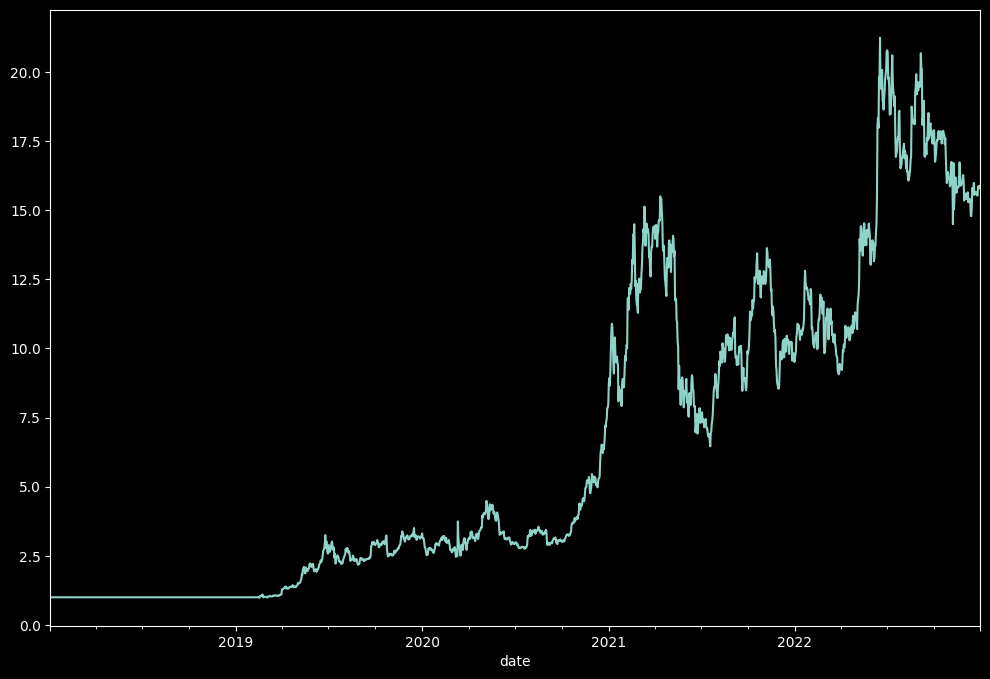

In [8]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
data['cumulative_return'] = (1 + data['sr_return']).cumprod()
data['cumulative_return'].plot()
plt.show()

In [9]:
long_trades

,entry_price,exit_time,exit_price,percent
entry_time,,,,
2019-02-17,3667.58,2019-09-13,10342.06,1.819859
2020-01-07,8145.28,2020-01-09,7817.76,-0.040210
2020-01-10,8197.02,2020-03-08,8033.31,-0.019972
2020-03-13,5578.60,2020-03-14,5172.06,-0.072875
2020-03-15,5361.30,2020-03-16,5028.97,-0.061987
2020-03-17,5312.64,2020-05-24,8720.34,0.641433
2020-05-25,8900.35,2020-05-29,9427.07,0.059180
2020-05-30,9697.72,2020-05-31,9448.27,-0.025723
2020-06-01,10200.77,2020-06-11,9280.40,-0.090226


In [10]:
short_trades

,entry_price,exit_time,exit_price,percent
entry_time,,,,
2019-02-13,3609.40,2019-02-17,3667.58,-0.016119
2019-09-13,10342.06,2020-01-07,8145.28,0.212412
2020-01-09,7817.76,2020-01-10,8197.02,-0.048513
2020-03-08,8033.31,2020-03-13,5578.60,0.305566
2020-03-14,5172.06,2020-03-15,5361.30,-0.036589
2020-03-16,5028.97,2020-03-17,5312.64,-0.056407
2020-05-24,8720.34,2020-05-25,8900.35,-0.020643
2020-05-29,9427.07,2020-05-30,9697.72,-0.028710
2020-05-31,9448.27,2020-06-01,10200.77,-0.079644
